In [200]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
accountname = 'nj07294.ap-southeast-1'
#accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

In [202]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

In [203]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [204]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",

    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

In [205]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

In [206]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 38 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int8   
 1   MONTH                                     540201 non-null  int8   
 2   HOUR                                      540201 non-null  int8   
 3   DOW                                       540201 non-null  int8   
 4   DAY                                       540201 non-null  int8   
 5   PUBLIC_HOLIDAY                            540201 non-null  int8   
 6   Profit                                    540201 non-null  float64
 7   LAT                                       540201 non-null  float64
 8   LONG                                      540201 non-null  float64
 9   LOCATION_ID                               540201 non-null  int16  
 10  SUM_DAY_OF_WEEK_AVG_

In [207]:
X_final_scaled.head()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,Profit,LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0


In [208]:
print(X_final_scaled.columns.tolist())

['TRUCK_ID', 'MONTH', 'HOUR', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'Profit', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']


In [209]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Profit",axis=1)
y = X_final_scaled["Profit"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

In [210]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns
import scipy.stats as stats

In [211]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
xgb = LGBMRegressor(n_estimators=500)
xgb.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  2968953.909487875
Test MSE is:  3260824.369489615

Train RMSE is:  1723.065265591491
Test RMSE is:  1805.7752821128145

Train MAE is:  1163.5308455133852
Test MAE is:  1198.4530543854682

Train R2 is:  0.9071514900595083
Test R2 is:  0.8982355271341209


In [212]:
# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = xgb.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)

        TRUCK_ID  MONTH  HOUR  DOW  DAY  PUBLIC_HOLIDAY        LAT  \
58027         50      5    10    1    9               0  42.247702   
386383        33      3    10    3   16               0  47.605014   
211458        45      7    17    5    1               0  47.588769   
455709        75     11    18    6   13               0  40.710351   
342396        42      5    11    6   14               0  47.575333   
...          ...    ...   ...  ...  ...             ...        ...   
209115        20      3    11    1   21               0  39.750623   
510853         3     10    13    5    7               0  37.557758   
199755        41     10     9    6   23               0  47.628276   
330459        33      8    17    2   31               0  47.526835   
256006        50     11    19    0    8               0  42.303791   

              LONG  LOCATION_ID  SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE  ...  \
58027   -71.129438        15284                           -0.372952  ...   
386383 

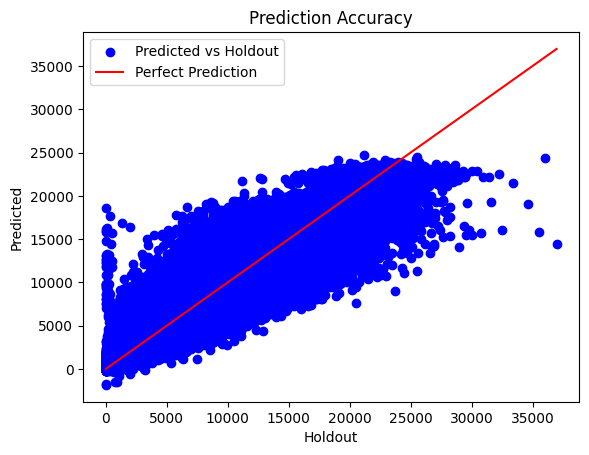

In [213]:
import matplotlib.pyplot as plt

# Plot the predicted values against the holdout values
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [214]:
# Get unique location IDs
unique_location_ids = X_final_scaled['LOCATION_ID'].unique()
print("Unique Location IDs:", unique_location_ids)

# Create a list to store the table data
table_data = []


# Create a DataFrame to store the table data
df_unique_locations_lat_long = pd.DataFrame(columns=["Location ID", "Latitude", "Longitude"])

# Iterate over each unique location ID
for location_id in unique_location_ids:
    location = X_final_scaled[X_final_scaled['LOCATION_ID'] == location_id]
    latitude = location['LAT'].values[0]
    longitude = location['LONG'].values[0]
    df_unique_locations_lat_long = pd.concat([df_unique_locations_lat_long, pd.DataFrame({"Location ID": [location_id],
                                                  "Latitude": [latitude],
                                                  "Longitude": [longitude]})],
                         ignore_index=True)

    

# Print the DataFrame
df_unique_locations_lat_long

Unique Location IDs: [ 3007  1606 15490 ...  4029 15332  2558]


,Location ID,Latitude,Longitude
0,3007,40.768807,-73.985856
1,1606,42.344888,-71.031757
2,15490,42.367153,-71.056455
3,3757,42.366770,-71.054887
4,1149,42.335266,-71.072024
...,...,...,...
1873,4117,37.568620,-122.325058
1874,15389,42.308397,-71.063827
1875,4029,42.362159,-71.058150
1876,15332,42.362928,-71.056870


Starting location recommendation

In [254]:
#User input
from datetime import datetime

#USER INPUT
truck_id = 43
date = '2020-8-25'
datetime_object = datetime.strptime(date, '%Y-%m-%d')
starting_hour = 8
ending_hour = 22
num_of_locs = 3
each_location_travel_distance = 8 #km
max_total_travel_distance= each_location_travel_distance * num_of_locs

df = pd.DataFrame({'TRUCK_ID': [truck_id],
                   'date': [date]})

#seperate date into month, dow, day, public_holiday
df['date'] = pd.to_datetime(df['date'])
df['MONTH'] = df['date'].dt.month
df['DOW'] = df['date'].dt.weekday
df['DAY'] = df['date'].dt.day
df['WOM'] = (df['DAY'] - 1) // 7 + 1

public_holidays = [
     {'Month': 7, 'Day': 4, 'DOW': None, 'WOM': None},  # 4th of July
   {'Month': 12, 'Day': 24, 'DOW': None, 'WOM': None},  # Christmas Eve
    {'Month': 12, 'Day': 25, 'DOW': None, 'WOM': None},  # Christmas Day
    {'Month': 10, 'Day': None, 'DOW': '0', 'WOM': 2},  # Columbus Day (second Monday in October)
    {'Month': 6, 'Day': 19, 'DOW': None, 'WOM': None},  # Juneteenth
    {'Month': 9, 'Day': None, 'DOW': '0', 'WOM': 1},  # Labor Day (first Monday in September)
    {'Month': 1, 'Day': None, 'DOW': '0', 'WOM': 3},  # Martin Luther King, Jr. Day (third Monday in January)
    {'Month': 5, 'Day': None, 'DOW': '0', 'WOM': -1},  # Memorial Day (last Monday in May)
    {'Month': 1, 'Day': 1, 'DOW': None, 'WOM': None},  # New Year's Day
    {'Month': 12, 'Day': 31, 'DOW': None, 'WOM': None},  # New Year's Eve
    {'Month': 11, 'Day': None, 'DOW': '3', 'WOM': 4},  # Thanksgiving Day (fourth Thursday in November)
    {'Month': 11, 'Day': None, 'DOW': '2', 'WOM': 4},  # Thanksgiving Eve (fourth Wednesday in November)
    {'Month': 2, 'Day': 14, 'DOW': None, 'WOM': None},  # Valentine's Day
    {'Month': 11, 'Day': 11, 'DOW': None, 'WOM': None},  # Veterans Day
    {'Month': 10, 'Day': 31, 'DOW': None, 'WOM': None},  # Halloween
    {'Month': 3, 'Day': 17, 'DOW': None, 'WOM': None},  # St. Patrick's Day
    {'Month': 11, 'Day': 25, 'DOW': '4', 'WOM': None},  # Black Friday
    {'Month': 12, 'Day': 26, 'DOW': None, 'WOM': None},  # Boxing Day
]

# Iterate over the public holidays and create the 'public_holiday' column
df['PUBLIC_HOLIDAY'] = 0  # Initialize the column with 0 (not a public holiday)
for holiday in public_holidays:
    month_mask = df['date'].dt.month == holiday['Month']
    day_mask = df['date'].dt.day == holiday['Day']
    dow_mask = df['date'].dt.dayofweek == int(holiday['DOW']) if holiday['DOW'] is not None else True
    wom_mask = (df['date'].dt.day - 1) // 7 + 1 == holiday['WOM'] if holiday['WOM'] is not None else True

    mask = month_mask & day_mask & dow_mask & wom_mask
    df.loc[mask, 'PUBLIC_HOLIDAY'] = 1

df.head()

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY
0,43,2020-08-25,8,1,25,4,0


In [255]:
#schema get Truck table + Location table, get location id, City + region
session.use_schema("RAW_POS")
query = "SELECT * FROM TRUCK WHERE TRUCK_ID = '{}'".format(truck_id)
truck_df=session.sql(query).toPandas()
#truck_df = truck_df[truck_df['TRUCK_ID']==truck_id]
city = truck_df['PRIMARY_CITY'].iloc[0]

query = "SELECT * FROM LOCATION WHERE CITY = '{}'".format(city)
location_df=session.sql(query).toPandas()
#location_df = location_df[location_df['CITY']==city]
city_locations = location_df.merge(df_unique_locations_lat_long, left_on='LOCATION_ID', right_on='Location ID', how='inner')
city_locations = city_locations[['LOCATION_ID','Latitude','Longitude']]
city_locations.rename(columns={"Latitude": "LAT"},inplace=True)
city_locations.rename(columns={"Longitude": "LONG"},inplace=True)

loc_checker = city_locations.copy()
loc_checker['DATE'] = date
wdf=session.sql("Select * from ANALYTICS.WEATHER_DATA_API")
wdf=wdf.withColumn("H",F.substring(wdf["TIME"], 12, 2).cast("integer"))
wdf=wdf.withColumn("DATE",F.substring(wdf["TIME"], 0, 10))
wdf=wdf.select("WEATHERCODE","LOCATION_ID","H","DATE" )
wdf=wdf.to_pandas()

In [256]:
wdf.head()

,WEATHERCODE,LOCATION_ID,H,DATE
0,53,5176,0,2020-01-01
1,53,5176,1,2020-01-01
2,51,5176,2,2020-01-01
3,53,5176,3,2020-01-01
4,51,5176,4,2020-01-01


In [257]:
len(wdf.index)

46629264

In [258]:
loc_checker.head()

,LOCATION_ID,LAT,LONG,DATE
0,1070,47.635086,-122.276460,2020-8-25
1,1071,47.709393,-122.322057,2020-8-25
2,1073,47.588110,-122.302136,2020-8-25
3,1074,47.642357,-122.310509,2020-8-25
4,1075,47.639800,-122.295238,2020-8-25


In [259]:
loc_checker['DATE']=pd.to_datetime(loc_checker['DATE'],format='%Y-%m-%d')
loc_checker.head()
len(loc_checker.index)

436

In [260]:
loc_checker['DATE']=loc_checker['DATE'].astype('str')
loc_checker.dtypes

LOCATION_ID     object
LAT            float64
LONG           float64
DATE            object
dtype: object

In [261]:
weadf = pd.merge(wdf, loc_checker, on=['LOCATION_ID', 'DATE']).drop_duplicates()

In [262]:
weadf[weadf['LOCATION_ID']==1070].head(10)

,WEATHERCODE,LOCATION_ID,H,DATE,LAT,LONG
5880,1,1070,0,2020-08-25,47.635086,-122.27646
5881,0,1070,1,2020-08-25,47.635086,-122.27646
5882,0,1070,2,2020-08-25,47.635086,-122.27646
5883,0,1070,3,2020-08-25,47.635086,-122.27646
5884,0,1070,4,2020-08-25,47.635086,-122.27646
5885,0,1070,5,2020-08-25,47.635086,-122.27646
5886,0,1070,6,2020-08-25,47.635086,-122.27646
5887,0,1070,7,2020-08-25,47.635086,-122.27646
5888,0,1070,8,2020-08-25,47.635086,-122.27646
5889,0,1070,9,2020-08-25,47.635086,-122.27646


In [263]:
df.head()

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY
0,43,2020-08-25,8,1,25,4,0


In [264]:
df['date']=df['date'].astype('str')

In [265]:
df['HOUR']=starting_hour
new_df = pd.merge(df, weadf,  how='left', left_on=['date','HOUR'], right_on = ['DATE','H']).drop_duplicates()
len(new_df.index)

436

In [266]:
new_df[new_df['WEATHERCODE']!=0].head()

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY,HOUR,WEATHERCODE,LOCATION_ID,H,DATE,LAT,LONG


In [267]:
filtered_df = X_final_scaled[X_final_scaled['TRUCK_ID'] == truck_id]
filtered_df = filtered_df[['TRUCK_ID', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 
                           'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
                         'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 
                         'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 
                         'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 
                         'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
merge_df = new_df.merge(filtered_df, left_on='TRUCK_ID', right_on='TRUCK_ID', how='inner').drop_duplicates()
merge_df
# 'MONTH','DAY', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY,HOUR,WEATHERCODE,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,43,2020-08-25,8,1,25,4,0,8,0,5176,...,1,0,0,0,0,0,0,0,1,0
6298,43,2020-08-25,8,1,25,4,0,8,0,2272,...,1,0,0,0,0,0,0,0,1,0
12596,43,2020-08-25,8,1,25,4,0,8,0,15104,...,1,0,0,0,0,0,0,0,1,0
18894,43,2020-08-25,8,1,25,4,0,8,0,3003,...,1,0,0,0,0,0,0,0,1,0
25192,43,2020-08-25,8,1,25,4,0,8,0,15088,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2714438,43,2020-08-25,8,1,25,4,0,8,0,15105,...,1,0,0,0,0,0,0,0,1,0
2720736,43,2020-08-25,8,1,25,4,0,8,0,2323,...,1,0,0,0,0,0,0,0,1,0
2727034,43,2020-08-25,8,1,25,4,0,8,0,4087,...,1,0,0,0,0,0,0,0,1,0
2733332,43,2020-08-25,8,1,25,4,0,8,0,15106,...,1,0,0,0,0,0,0,0,1,0


In [268]:
from datetime import timedelta
filtered_df = X_final_scaled[(X_final_scaled['TRUCK_ID'] == truck_id) & (X_final_scaled['HOUR'] == 8)]
filtered_df = filtered_df[['TRUCK_ID', 'MONTH','DAY', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']]
merged_df = pd.merge(merge_df, filtered_df, on=['TRUCK_ID', 'MONTH','DAY'], how='left').drop_duplicates()

merged_df = merged_df.sort_values(by=['TRUCK_ID', 'MONTH','DAY'])

# Backward fill null values with the closest non-null values
merged_df['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].fillna(method='bfill', inplace=True)
merged_df['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].fillna(method='bfill', inplace=True)

# Forward fill remaining null values if any
merged_df['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].fillna(method='ffill', inplace=True)
merged_df['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].fillna(method='ffill', inplace=True)


# Reset the index of the merged DataFrame
merged_df = merged_df.reset_index(drop=True)
merged_df['LOCATION_ID'] = merged_df['LOCATION_ID'].astype(int)
merged_df

,TRUCK_ID,date,MONTH,DOW,DAY,WOM,PUBLIC_HOLIDAY,HOUR,WEATHERCODE,LOCATION_ID,...,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE
0,43,2020-08-25,8,1,25,4,0,8,0,5176,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
1,43,2020-08-25,8,1,25,4,0,8,0,5176,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
2,43,2020-08-25,8,1,25,4,0,8,0,2272,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
3,43,2020-08-25,8,1,25,4,0,8,0,2272,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
4,43,2020-08-25,8,1,25,4,0,8,0,15104,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,43,2020-08-25,8,1,25,4,0,8,0,4087,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
868,43,2020-08-25,8,1,25,4,0,8,0,15106,...,0,0,0,0,0,0,1,0,-0.002259,0.376878
869,43,2020-08-25,8,1,25,4,0,8,0,15106,...,0,0,0,0,0,0,1,0,0.141936,-0.230249
870,43,2020-08-25,8,1,25,4,0,8,0,2558,...,0,0,0,0,0,0,1,0,-0.002259,0.376878


In [269]:
print(merged_df.columns.tolist())

['TRUCK_ID', 'date', 'MONTH', 'DOW', 'DAY', 'WOM', 'PUBLIC_HOLIDAY', 'HOUR', 'WEATHERCODE', 'LOCATION_ID', 'H', 'DATE', 'LAT', 'LONG', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']


In [270]:
import math
import pandas as pd

def calculate_distances(df_predictions, starting_location_id):
    def haversine_distance(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = 6371 * c  # Radius of the Earth in kilometers
        return distance

    # Find the reference location based on the starting location ID
    reference_location = df_predictions[df_predictions['LOCATION_ID'] == starting_location_id]
    reference_latitude = reference_location['LAT'].values[0]
    reference_longitude = reference_location['LONG'].values[0]

    # List of other locations with their respective location IDs, latitudes, and longitudes
    other_locations = df_predictions[['LOCATION_ID', 'LAT', 'LONG']].drop_duplicates().values.tolist()

    # Calculate distances between starting location and other locations
    distances = []
    for location in other_locations:
        location_id = location[0]
        latitude = location[1]
        longitude = location[2]
        distance = haversine_distance(reference_latitude, reference_longitude, latitude, longitude)
        distances.append({'Location_ID_start': starting_location_id, 'Location_ID_end': location_id, 'distance': distance})

    # Create a DataFrame from the distances list
    df_distances = pd.DataFrame(distances)

    # Sort the DataFrame by distance in ascending order
    df_distances = df_distances.sort_values('distance')

    return df_distances

# Example usage
reference_location_id = 5176
df_distances = calculate_distances(df_predictions, reference_location_id)
print(f"Test Distances from Location ID {reference_location_id}:")
df_distances

Test Distances from Location ID 5176:


,Location_ID_start,Location_ID_end,distance
500,5176,5176.0,0.000000
506,5176,2762.0,0.926345
208,5176,3003.0,0.963089
1113,5176,5174.0,1.191913
1649,5176,15086.0,1.195572
...,...,...,...
1167,5176,3731.0,4010.418755
1636,5176,15226.0,4013.935552
1298,5176,15221.0,4015.038004
42,5176,5236.0,4015.471760


## Routing Algorithm

In [271]:
starting_hour = starting_hour
ending_hour = ending_hour
num_of_locs = num_of_locs
working_hours = ending_hour - starting_hour
# Calculate the base shift hours (without considering the remainder)
shift_hours = working_hours // num_of_locs
# Calculate the remaining hours to distribute
remaining_hours = working_hours % num_of_locs

# Create a list to store the shift hours for each shift
shift_hours_list = [shift_hours] * num_of_locs

# Distribute the remaining hours evenly across shifts
for i in range(remaining_hours):
    shift_hours_list[i] += 1

In [272]:
initial_df_position = merged_df[['TRUCK_ID', 'MONTH', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 
 'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 
 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 
 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
initial_df_position

,TRUCK_ID,MONTH,DOW,DAY,PUBLIC_HOLIDAY,LAT,LONG,LOCATION_ID,SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE,SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,43,8,1,25,0,47.573410,-122.375880,5176,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
1,43,8,1,25,0,47.573410,-122.375880,5176,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
2,43,8,1,25,0,47.561638,-122.376698,2272,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
3,43,8,1,25,0,47.561638,-122.376698,2272,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
4,43,8,1,25,0,47.538454,-122.381150,15104,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,43,8,1,25,0,47.607885,-122.340977,4087,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
868,43,8,1,25,0,47.527442,-122.396525,15106,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0
869,43,8,1,25,0,47.527442,-122.396525,15106,0.141936,-0.230249,...,1,0,0,0,0,0,0,0,1,0
870,43,8,1,25,0,47.554318,-122.329291,2558,-0.002259,0.376878,...,1,0,0,0,0,0,0,0,1,0


In [273]:
current_hour = starting_hour
initial_df_position['HOUR'] = current_hour
initial_df_position['Predicted'] = xgb.predict(initial_df_position)
for x in range(shift_hours_list[0]):
    current_hour += 1
    initial_df_position['HOUR'] = current_hour
    next_df_prediction = initial_df_position.copy().drop(columns = 'Predicted')
    initial_df_position['Predicted'] += xgb.predict(next_df_prediction)

max_index = initial_df_position['Predicted'].idxmax()
row_with_max_value = initial_df_position.loc[max_index]
row_with_max_value['HOUR'] = starting_hour
row_with_max_value

C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\1560449313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df_position['HOUR'] = current_hour
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\1560449313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df_position['Predicted'] = xgb.predict(initial_df_position)
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\1560449313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

TRUCK_ID                                       43.000000
MONTH                                           8.000000
DOW                                             1.000000
DAY                                            25.000000
PUBLIC_HOLIDAY                                  0.000000
LAT                                            47.573410
LONG                                         -122.375880
LOCATION_ID                                  5176.000000
SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE             -0.002259
SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE        0.376878
WEATHERCODE                                     0.000000
MENU_TYPE_GYROS_ENCODED                         0.000000
MENU_TYPE_CREPES_ENCODED                        0.000000
MENU_TYPE_BBQ_ENCODED                           0.000000
MENU_TYPE_SANDWICHES_ENCODED                    0.000000
MENU_TYPE_Mac & Cheese_encoded                  0.000000
MENU_TYPE_POUTINE_ENCODED                       0.000000
MENU_TYPE_ETHIOPIAN_ENCODED    

In [274]:
route_list = [row_with_max_value]
hour = starting_hour
for x in range(num_of_locs-1):
    hour += shift_hours_list[x] #add on hours to predict at later hours
    df_distances = calculate_distances(merged_df, route_list[x]['LOCATION_ID']) #calculate distance to all location IDs
    filtered_distances = df_distances[(df_distances['Location_ID_start'] == route_list[x]['LOCATION_ID']) & (df_distances['distance'] < each_location_travel_distance)]
    result = merged_df[merged_df['LOCATION_ID'].isin(filtered_distances['Location_ID_end'])]
    current_hour = hour
    result['HOUR'] = current_hour
    result = result[['TRUCK_ID', 'MONTH', 'HOUR', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 
        'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 
        'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 
        'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 
        'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']]
    result['Predicted'] = xgb.predict(result)
    for x in range(shift_hours_list[0]):
        current_hour += 1
        result['HOUR'] = current_hour
        next_df_prediction = result.copy().drop(columns = 'Predicted')
        result['Predicted'] += xgb.predict(next_df_prediction)
        
    max_index = result['Predicted'].idxmax()
    max_value = result.loc[max_index]
    max_value['HOUR'] = hour
    route_list.append(max_value)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\789243467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['HOUR'] = current_hour
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\789243467.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_value['HOUR'] = hour
C:\Users\Nathan\AppData\Local\Temp\ipykernel_28452\789243467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [275]:
# Filter the X_holdout DataFrame for the specified day, month, and truck ID
filtered_holdout = X_final_scaled[(X_final_scaled['DAY'] == 25) & (X_final_scaled['MONTH'] == 8) & (X_final_scaled['TRUCK_ID'] == 43)]

# Extract relevant columns for analysis
hourly_values = filtered_holdout[['HOUR', 'Profit']]

hour_value_list = []
Initial_locations = []
hour_list = list(range(starting_hour, ending_hour))

for i in range(len(shift_hours_list)):
    hour_value = 0.0
    shift_hours= shift_hours_list[i]
    # print(hour_list)

    for j in range(shift_hours):
        hour = hour_list[0]
        # print(type(hour))
        hour_list.remove(hour)
        # print(hour)
        filter_hour = filtered_holdout[(filtered_holdout['HOUR'] == hour)]
        hour_value += filter_hour['Profit'].values[0]


    hour_value_list.append(hour_value)
    filter_loc = filtered_holdout[(filtered_holdout['HOUR'] == hour)]
    Initial_locations.append(filter_loc['LOCATION_ID'].values[0])


In [276]:
for i in range(len(route_list)):
    print('Hour:',route_list[i]['HOUR'])
    print('Shift Hours:',shift_hours_list[i])
    print('Location ID:', route_list[i]['LOCATION_ID'])
    print('Total predicted value:', route_list[i]['Predicted'])
    print('Total initial value:', hour_value_list[i])
    print('Additional Value', route_list[i]['Predicted']- hour_value_list[i])
    print('Original Location: ', Initial_locations[i])
    print()

print('Maximum distance travelled throughout all the shifts for truck id',truck_id,": ",max_total_travel_distance,'km')

Hour: 8.0
Shift Hours: 5
Location ID: 5176.0
Total predicted value: 45825.612753859794
Total initial value: 36294.0
Additional Value 9531.612753859794
Original Location:  15043

Hour: 13.0
Shift Hours: 5
Location ID: 15502.0
Total predicted value: 35360.43748295913
Total initial value: 19834.0
Additional Value 15526.437482959132
Original Location:  5176

Hour: 18.0
Shift Hours: 4
Location ID: 15502.0
Total predicted value: 38448.92302402776
Total initial value: 38070.0
Additional Value 378.92302402776113
Original Location:  5176

Maximum distance travelled throughout all the shifts for truck id 43 :  24 km


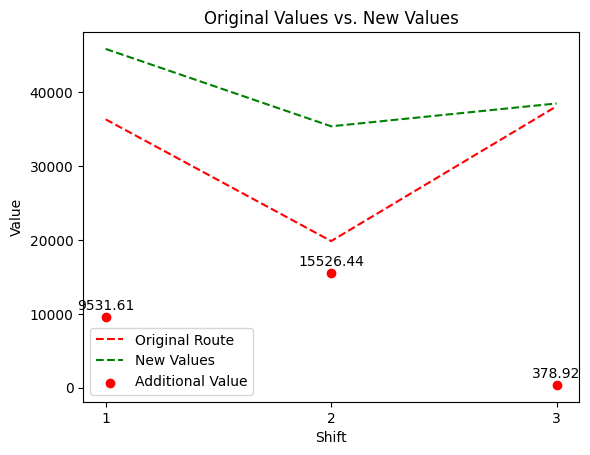

In [277]:
import matplotlib.pyplot as plt

# Extract the original and new values from the route_list
original_values = [hour_value for hour_value in hour_value_list]
new_values = [route['Predicted'] for route in route_list]
additional_values = [route['Predicted'] - hour_value for route, hour_value in zip(route_list, hour_value_list)]

# Create a list of shifts based on shift_hours_list
shifts = []
for shift_hours in shift_hours_list:
    shifts.extend([i + 1 for i in range(shift_hours)])

# Make sure the shifts and original_values have the same length
shifts = shifts[:len(original_values)]
shifts = [number for number in range(1, len(shift_hours_list) +1)]

# Plot the original and new values
plt.plot(shifts, original_values, color='red', linestyle='--',label='Original Route')
plt.plot(shifts, new_values,color='green', linestyle='--', label='New Values')

# Plot the additional values as dots
plt.scatter(shifts, additional_values, c='red', label='Additional Value')

# Add annotations for the additional values
for shift, value, additional in zip(shifts, additional_values, additional_values):
    plt.annotate(f'{round(additional,2)}', xy=(shift, value), xytext=(shift, value+1000), ha='center')

# Set the x-axis tick locations
plt.xticks(shifts)

# Add labels and title to the plot
plt.xlabel('Shift')
plt.ylabel('Value')
plt.title('Original Values vs. New Values')

# Add a legend
plt.legend()

# Display the plot
plt.show()
